In [1]:
import tensorflow as tf
import os
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [2]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import cv2
import imghdr
data_dir = '/content/drive/MyDrive/Sclera_dataset/jnjimages'
image_exts = ['jpeg','jpg', 'bmp', 'png']

Applying Trained Eyes Segmentation Model on Dataset

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [1]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [2]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name='timm-efficientnet-b0',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks!= None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)

      return logits,loss1+loss2

    return logits

In [5]:
#import model
model=SegmentationModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/Sclera_dataset/best_model_timm-efficientnet-b0.pt'))


<All keys matched successfully>

In [6]:
model.eval()

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [ ]:
# Apply model to test dataset
with torch.no_grad():
    for images, image_names in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for img_name, pred in zip(image_names, predicted):
            print(f"Image: {img_name}, Predicted class: {pred.item()}")

In [370]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_names = os.listdir(image_folder)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_names[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[idx]

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load test dataset
test_dataset = CustomDataset(image_folder='/content/drive/MyDrive/Sclera_dataset/jnjimages/Eyes', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [372]:
output_folder = '/content/drive/MyDrive/Sclera_dataset/jnjimages/seg_eye'

In [297]:
# # Helper function to overlay mask on image
def overlay_mask(image, mask, alpha=0.8):
    """Overlay mask on image."""
    mask_np = mask.numpy().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    mask = mask.numpy().transpose(1, 2, 0)
    overlay = image * (1 - alpha) + image*mask
    return overlay


In [ ]:
# Apply model to test dataset
with torch.no_grad():
    for images, image_names in test_loader:
        outputs = model(images)
        pred_mask=torch.sigmoid(outputs)
        pred_mask=(pred_mask>0.5)*1.0
        # _, predicted = torch.max(outputs, 1)

        for img_name, img, pred in zip(image_names,images, pred_mask):
            # Save the segmented image
            segmented_img = overlay_mask(img, pred)
            segmented_img = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)
            segmented_img_pil = Image.fromarray((segmented_img * 128).astype(np.uint8))
            segmented_img_pil.save(os.path.join(output_folder, img_name))

            print(f"Image: {img_name}, Predicted class: {pred_mask}")

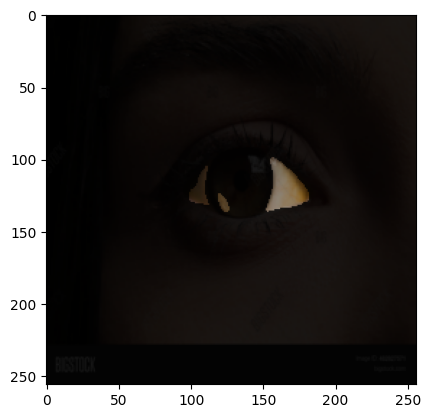

In [362]:
plt.imshow(segmented_img)

Classification of jaundice and not jaundice

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [6]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/Sclera_dataset/segmented_images')

In [7]:
data_dir

PosixPath('/content/drive/MyDrive/Sclera_dataset/segmented_images')

/content/drive/MyDrive/Sclera_dataset/segmented_images/seg_eye/subtle-winged-cats-eye.jpg


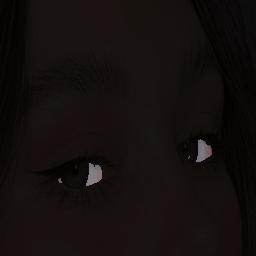

In [29]:
eyes = list(data_dir.glob('seg_eye/*'))
print(eyes[1])
PIL.Image.open(str(eyes[1]))

In [11]:
img_height,img_width=256,256
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375 files belonging to 2 classes.
Using 300 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375 files belonging to 2 classes.
Using 75 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['seg_eye', 'seg_jaun_eye ']


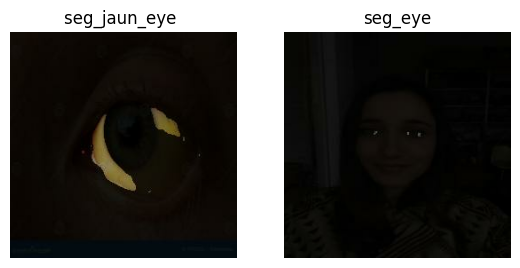

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

94765736/94765736 [==============================] - 0s 0us/step


In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 64)                131136    
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 1)                 65        
 apper)                                                          
                                                                 
Total params: 23718913 (90.48 MB)
Trainable params: 131201 (512.50 KB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [21]:
resnet_model.compile(optimizer=Adam(lr=0.005),loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 132s 13s/step - loss: 0.8266 - accuracy: 0.5633 - val_loss: 0.5088 - val_accuracy: 0.7733
Epoch 2/10
10/10 [==============================] - 109s 11s/step - loss: 0.5304 - accuracy: 0.7400 - val_loss: 0.4234 - val_accuracy: 0.8133
Epoch 3/10
10/10 [==============================] - 102s 10s/step - loss: 0.3919 - accuracy: 0.8467 - val_loss: 0.2838 - val_accuracy: 0.9333
Epoch 4/10
10/10 [==============================] - 105s 11s/step - loss: 0.2903 - accuracy: 0.8967 - val_loss: 0.2011 - val_accuracy: 0.9733
Epoch 5/10
10/10 [==============================] - 110s 11s/step - loss: 0.2302 - accuracy: 0.9267 - val_loss: 0.1710 - val_accuracy: 0.9733
Epoch 6/10
10/10 [==============================] - 106s 11s/step - loss: 0.1859 - accuracy: 0.9400 - val_loss: 0.1515 - val_accuracy: 0.9867
Epoch 7/10
10/10 [==============================] - 104s 11s/step - loss: 0.1810 - accuracy: 0.9400 - val_loss: 0.1337 - val_accuracy: 0.9867
Epoch 

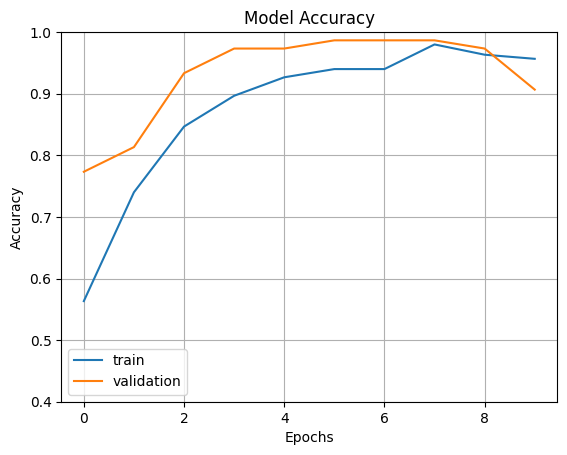

In [24]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

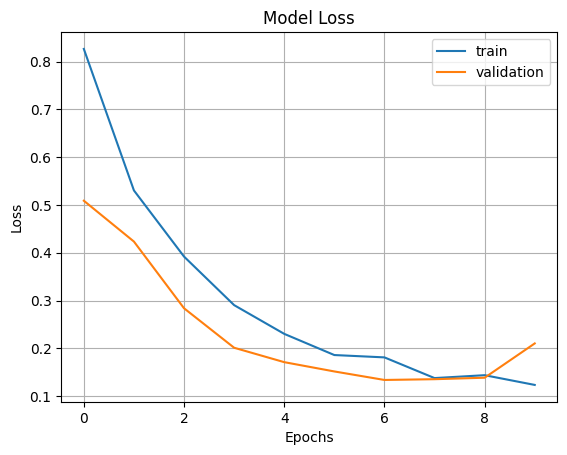

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [26]:
import cv2
image=cv2.imread(str(eyes[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 256, 256, 3)


In [27]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.02483941]]


In [28]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)


The predicted class is seg_eye
